<a href="https://colab.research.google.com/github/xzsevog/HeartDiseaseMIMICPrediction/blob/main/ProjektFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data retrieval and processing

##Imports

In [ ]:
# ────────────────────────────────────────────────────────────────
# Standard library
# ────────────────────────────────────────────────────────────────
import gc
import logging
import os
import warnings
from typing import Any, Dict, List

# ────────────────────────────────────────────────────────────────
# Data manipulation & numerics
# ────────────────────────────────────────────────────────────────
import numpy as np
import pandas as pd

# ────────────────────────────────────────────────────────────────
# Visualization
# ────────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_importance

# ────────────────────────────────────────────────────────────────
# Machine Learning & models
# ────────────────────────────────────────────────────────────────
import kagglehub
import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer

##Functions for preprocessing

In [ ]:
# --- CONFIGURATION ---
DATASET_HANDLE = "chanhainguyen/mimic-iii"
OUTPUT_FILE = 'MIMIC_III_Ext_Final_Dataset.xlsx'
MISSING_THRESHOLD = 0.8
CHUNK_SIZE = 300000

CARDIAC_ITEMIDS: Dict[str, List[int]] = {
    'heart_rate': [211, 220045],
    'bp_systolic': [51, 442, 455, 6701, 220179],
    'bp_diastolic': [8368, 8440, 8441, 8555, 220180],
    'resp_rate': [614, 615, 618, 219, 220210],
    'spo2': [646, 220277],
    'temp': [223761, 223762],
    'cvp': [113, 110, 220074],
    'troponin': [51003, 51002, 51004],
    'ck_mb': [50911],
    'bnp': [50912],
    'nt_probnp': [50963],
    'potassium': [50971],
    'sodium': [50983],
    'calcium': [50893],
    'magnesium': [50960],
    'cholesterol': [50907],
    'ldl': [50913],
    'hdl': [50910],
    'triglycerides': [50916],
    'crp': [50914],
    'esr': [51266],
    'creatinine': [50912],
    'bun': [51006],
    'ast': [50878],
    'alt': [50861],
    'bilirubin': [50885]
}

USECOLS = {
    'PATIENTS': ['SUBJECT_ID', 'GENDER'],
    'DIAGNOSES_ICD': ['SUBJECT_ID', 'ICD9_CODE'],
    'LABEVENTS': ['SUBJECT_ID', 'ITEMID', 'VALUENUM'],
    'CHARTEVENTS': ['SUBJECT_ID', 'ITEMID', 'VALUENUM']
}

HEART_DISEASE_RANGES = [391, range(393, 399), range(410, 415), 415, 416, range(420, 430)]
RESPIRATORY_RANGES = range(460, 520)
DIABETES_CODE = 250
RENAL_RANGES = range(580, 590)
LIVER_RANGES = range(570, 580)

# --- UTILITY FUNCTIONS ---

def safe_int_conversion(code_str: Any) -> int:
    """Safely converts an ICD code string to its first 3-digit integer.

    Args:
        code_str (Any): The ICD code as a string or other type.

    Returns:
        int: The first 3 digits of the ICD code as an integer, or 0 if conversion fails.
    """
    try:
        clean_str = ''.join(filter(str.isdigit, str(code_str)))
        if clean_str and len(clean_str) >= 3:
            return int(clean_str[:3])
        return 0
    except:
        return 0

def load_and_filter_table(table_name: str, relevant_ids: List[int] = None) -> pd.DataFrame:
    """Loads a specified MIMIC-III table, optionally filtering by ITEM_IDs, in chunks.

    This function downloads/locates the specified CSV file, reads it in chunks
    to optimize memory, and filters rows based on a list of relevant ITEM_IDs.

    Args:
        table_name (str): The name of the table to load (e.g., 'DIAGNOSES_ICD').
        relevant_ids (List[int], optional): A list of ITEM_IDs to filter by.
                                            If None, all rows are kept. Defaults to None.

    Returns:
        pd.DataFrame: A DataFrame containing the loaded and filtered data.
                      Returns an empty DataFrame if loading fails or no data matches.
    """
    print(f" Attempting to load {table_name}...")
    base_path = kagglehub.dataset_download(DATASET_HANDLE)
    print(f" Data for {table_name} located at {base_path}. Reading CSV...")

    file_path = os.path.join(base_path, f"{table_name}.csv", f"{table_name}.csv")

    chunks = []
    try:
        for chunk in pd.read_csv(file_path, chunksize=CHUNK_SIZE, usecols=USECOLS[table_name], low_memory=False):
            if 'SUBJECT_ID' in chunk.columns: chunk['SUBJECT_ID'] = chunk['SUBJECT_ID'].astype('int32')
            if 'ITEMID' in chunk.columns: chunk['ITEMID'] = chunk['ITEMID'].astype('int32')
            if relevant_ids: chunk = chunk[chunk['ITEMID'].isin(relevant_ids)]
            if not chunk.empty: chunks.append(chunk)

        df = pd.concat(chunks, ignore_index=True)
        print(f" Successfully loaded {table_name} ({len(df)} rows).")
        return df
    except Exception as e:
        print(f" Error loading {table_name}: {e}")
        return pd.DataFrame()

def process_measurements(data: pd.DataFrame) -> pd.DataFrame:
    """Processes raw measurement data by mapping ITEMIDs to parameter names and pivoting.

    Calculates the median value for each parameter per subject and pivots the table.

    Args:
        data (pd.DataFrame): DataFrame with 'SUBJECT_ID', 'ITEMID', and 'VALUENUM' columns.

    Returns:
        pd.DataFrame: A pivoted DataFrame with subjects as rows and parameters as columns,
                      containing median values.
    """
    if data.empty: return pd.DataFrame(columns=['SUBJECT_ID'])
    mapping = {iid: name for name, ids in CARDIAC_ITEMIDS.items() for iid in ids}
    data['param_name'] = data['ITEMID'].map(mapping)
    data = data[data['param_name'].notna()]
    data['VALUENUM'] = pd.to_numeric(data['VALUENUM'], errors='coerce')
    return data.groupby(['SUBJECT_ID', 'param_name'])['VALUENUM'].median().unstack().reset_index()

def create_comorbidity_features(icd_codes: List[str]) -> Dict[str, Any]:
    """Generates comorbidity features based on a list of ICD-9 codes.

    Args:
        icd_codes (List[str]): A list of ICD-9 codes for a single patient.

    Returns:
        Dict[str, Any]: A dictionary containing binary comorbidity flags and a count of comorbidities.
    """
    comorb = {'respiratory': 0, 'diabetes': 0, 'renal': 0, 'liver': 0, 'other_comorb': 0, 'comorb_count': 0}
    unique_non_cardiac_codes = set() # Use a set to store unique non-cardiac codes

    for code in icd_codes:
        c3 = safe_int_conversion(code)
        if c3 == 0: continue
        is_cardiac = any((isinstance(r, int) and c3 == r) or (isinstance(r, range) and c3 in r) for r in HEART_DISEASE_RANGES)

        if not is_cardiac:
            unique_non_cardiac_codes.add(c3) # Add the code to the set if it's a non-cardiac comorbidity
            if c3 in RESPIRATORY_RANGES: comorb['respiratory'] = 1
            elif c3 == DIABETES_CODE: comorb['diabetes'] = 1
            elif c3 in RENAL_RANGES: comorb['renal'] = 1
            elif c3 in LIVER_RANGES: comorb['liver'] = 1
            else: comorb['other_comorb'] = 1

    comorb['comorb_count'] = len(unique_non_cardiac_codes) # Set comorb_count to the number of unique non-cardiac codes

    return comorb

def create_feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    """Creates new composite features from existing columns in the DataFrame.

    Currently generates Mean Arterial Pressure, Pulse Pressure, and Chol/HDL ratio.

    Args:
        df (pd.DataFrame): The input DataFrame containing patient data.

    Returns:
        pd.DataFrame: The DataFrame with newly engineered features
    """
    print(" Creating new composite features and missingness indicators...")
    # Existing feature engineering
    if 'bp_systolic' in df.columns and 'bp_diastolic' in df.columns:
        df['mean_arterial_pressure'] = df['bp_diastolic'] + 1/3 * (df['bp_systolic'] - df['bp_diastolic'])
        df['pulse_pressure'] = df['bp_systolic'] - df['bp_diastolic']
    if 'cholesterol' in df.columns and 'hdl' in df.columns:
        df['chol_hdl_ratio'] = df['cholesterol'] / df['hdl']
    if 'creatinine' in df.columns and 'is_male' in df.columns:
        df['egfr_approx'] = 175 * (df['creatinine'] ** -1.154)
        df['egfr_approx'] *= df['is_male'].apply(lambda x: 1.0 if x == 1 else 0.742)

    return df

##File preprocessing

In [ ]:

if __name__ == "__main__":
    print("MIMIC-III-Ext: Starting Memory-Optimized Pipeline\n")

    # 1. Target & Comorbidities
    diag_raw = load_and_filter_table("DIAGNOSES_ICD")
    grouped_codes = diag_raw.groupby('SUBJECT_ID')['ICD9_CODE'].apply(list).reset_index()

    print(" Processing Diagnoses (Target + Comorbidities)...")
    target_results = []
    comorb_results = []

    for _, row in grouped_codes.iterrows():
        codes = row['ICD9_CODE']
        sid = row['SUBJECT_ID']

        # Check Heart Disease (Target)
        has_hd = 0
        for c in codes:
            c3 = safe_int_conversion(c)
            if any((isinstance(r, int) and c3 == r) or (isinstance(r, range) and c3 in r) for r in HEART_DISEASE_RANGES):
                has_hd = 1
                break

        target_results.append({'SUBJECT_ID': sid, 'has_heart_disease': has_hd})
        comorb_results.append({'SUBJECT_ID': sid, **create_comorbidity_features(codes)})

    target_df = pd.DataFrame(target_results)
    comorbidities_df = pd.DataFrame(comorb_results)
    del diag_raw, grouped_codes
    gc.collect()

    # 2. Patients
    pat_raw = load_and_filter_table("PATIENTS")
    pat_raw['is_male'] = (pat_raw['GENDER'] == 'M').astype(int)
    patients_df = pat_raw[['SUBJECT_ID', 'is_male']]
    del pat_raw
    gc.collect()

    # 3. Lab & Chart Measurements
    l_ids = [i for p, ids in CARDIAC_ITEMIDS.items() if p not in ['heart_rate', 'bp_systolic', 'bp_diastolic', 'resp_rate', 'spo2', 'temp', 'cvp'] for i in ids]
    lab_pivot = process_measurements(load_and_filter_table("LABEVENTS", l_ids))

    c_ids = [i for p, ids in CARDIAC_ITEMIDS.items() if p in ['heart_rate', 'bp_systolic', 'bp_diastolic', 'resp_rate', 'spo2', 'temp', 'cvp'] for i in ids]
    chart_pivot = process_measurements(load_and_filter_table("CHARTEVENTS", c_ids))
    gc.collect()

    # 4. Merging
    print("\n Merging all features...")
    df_final = patients_df.merge(target_df, on='SUBJECT_ID', how='inner')\
                       .merge(comorbidities_df, on='SUBJECT_ID', how='left')\
                       .merge(lab_pivot, on='SUBJECT_ID', how='left')\
                       .merge(chart_pivot, on='SUBJECT_ID', how='left')

    # 5. Feature Engineering & Cleaning
    df_final = create_feature_engineering(df_final)
    df_final.drop(columns=["SUBJECT_ID"])

    # 6. Save
    df_final.to_excel(OUTPUT_FILE, index=False)
    print(f"\n Done! File saved as {OUTPUT_FILE}")

MIMIC-III-Ext: Starting Memory-Optimized Pipeline

 Attempting to load DIAGNOSES_ICD...


KeyboardInterrupt: 

# EDA and ML model comparison

##EDA



In [ ]:
print('DataFrame Info:')
df_final = pd.read_excel("MIMIC_III_Ext_Final_Dataset.xlsx")
df_final.drop(columns=["SUBJECT_ID"],inplace=True)
df_final.info()

print('\nMissing values percentage:')
missing_percentage = df_final.isnull().sum() / len(df_final) * 100
print(missing_percentage[missing_percentage > 0].sort_values(ascending=False))

print('\nDescriptive Statistics:')
print(df_final.describe())

df_final = df_final.replace([np.inf, -np.inf], np.nan)


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46520 entries, 0 to 46519
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   is_male                 46520 non-null  int64  
 1   has_heart_disease       46520 non-null  int64  
 2   respiratory             46520 non-null  int64  
 3   diabetes                46520 non-null  int64  
 4   renal                   46520 non-null  int64  
 5   liver                   46520 non-null  int64  
 6   other_comorb            46520 non-null  int64  
 7   comorb_count            46520 non-null  int64  
 8   alt                     30207 non-null  float64
 9   ast                     30123 non-null  float64
 10  bilirubin               35677 non-null  float64
 11  bun                     39361 non-null  float64
 12  calcium                 37993 non-null  float64
 13  cholesterol             10479 non-null  float64
 14  ck_mb                 

##Post EDA activites




### Dropping columns with NaN >=70%

In [ ]:
# Identify columns with missing values greater than or equal to 70%
cols_to_drop_high_missing = missing_percentage[missing_percentage >= 70].index.tolist()

if cols_to_drop_high_missing:
  print(f"Dropping columns with >= 70% missing values: {cols_to_drop_high_missing}")
  df_final.drop(columns=cols_to_drop_high_missing, inplace=True)
else:
  print("No columns to drop based on 70% missing value threshold.")

# Print the missing percentage for the remaining columns (those < 70%)
print(f"\nMissing percentages for columns after dropping those with >= 70% missing values:")
remaining_missing_percentage = df_final.isnull().sum() / len(df_final) * 100
print(remaining_missing_percentage[remaining_missing_percentage > 0].sort_values(ascending=False))


Dropping columns with >= 70% missing values: ['cholesterol', 'crp', 'esr', 'ldl', 'nt_probnp', 'triglycerides', 'chol_hdl_ratio']

Missing percentages for columns after dropping those with >= 70% missing values:
troponin                  68.804815
cvp                       64.161651
temp                      62.121668
ck_mb                     58.293207
hdl                       46.850817
ast                       35.247206
alt                       35.066638
bilirubin                 23.308255
calcium                   18.329751
pulse_pressure            17.777300
bp_diastolic              17.777300
mean_arterial_pressure    17.777300
bp_systolic               17.777300
magnesium                 17.487102
spo2                      17.457008
resp_rate                 17.441960
egfr_approx               15.417025
creatinine                15.414875
bun                       15.389080
potassium                 11.418745
sodium                    11.416595
heart_rate                 1.143

###Adding missing tests flag

In [ ]:
# Dynamically identify columns that still have missing values after initial drops
# These are the columns for which we want to create missing flags
high_missing_cols_to_flag = remaining_missing_percentage[remaining_missing_percentage > 0].index.tolist()

# Ensure we only consider columns that are actually present in df_final and are numeric
numeric_cols_with_missing = [col for col in high_missing_cols_to_flag if col in df_final.columns and df_final[col].dtype in ['float64', 'int64']]

print(f"Adding missing_flags for {len(numeric_cols_with_missing)} columns.")

for col in numeric_cols_with_missing:
    flag_col = f"{col}_missing"
    if flag_col not in df_final.columns: # Prevent re-creating if already exists
        df_final[flag_col] = df_final[col].isna().astype(int)

# Update flag_cols with the newly created flags
flag_cols = [f"{col}_missing" for col in numeric_cols_with_missing if f"{col}_missing" in df_final.columns]

for flag_col_name in flag_cols:
    print(f"{flag_col_name}: {df_final[flag_col_name].mean():.4f} ({df_final[flag_col_name].mean()*100:.2f}%)")

# Ensure SUBJECT_ID is dropped if it exists before creating numeric_cols
if 'SUBJECT_ID' in df_final.columns:
    df_final.drop(columns=['SUBJECT_ID'], inplace=True)

# Redefine numeric_cols to ensure it is accurate, excluding the target and comorbidity flags
numeric_cols = df_final.select_dtypes(include=['float64', 'int64']).columns.difference(
    ['has_heart_disease', 'other_comorb', 'respiratory', 'diabetes', 'renal', 'liver'] + flag_cols
)


Adding missing_flags for 22 columns.
alt_missing: 0.3507 (35.07%)
ast_missing: 0.3525 (35.25%)
bilirubin_missing: 0.2331 (23.31%)
bun_missing: 0.1539 (15.39%)
calcium_missing: 0.1833 (18.33%)
ck_mb_missing: 0.5829 (58.29%)
creatinine_missing: 0.1541 (15.41%)
hdl_missing: 0.4685 (46.85%)
magnesium_missing: 0.1749 (17.49%)
potassium_missing: 0.1142 (11.42%)
sodium_missing: 0.1142 (11.42%)
troponin_missing: 0.6880 (68.80%)
bp_diastolic_missing: 0.1778 (17.78%)
bp_systolic_missing: 0.1778 (17.78%)
cvp_missing: 0.6416 (64.16%)
heart_rate_missing: 0.0114 (1.14%)
resp_rate_missing: 0.1744 (17.44%)
spo2_missing: 0.1746 (17.46%)
temp_missing: 0.6212 (62.12%)
mean_arterial_pressure_missing: 0.1778 (17.78%)
pulse_pressure_missing: 0.1778 (17.78%)
egfr_approx_missing: 0.1542 (15.42%)


### Median imputation for selected columns with missing values

In [ ]:

imputer = SimpleImputer(strategy='median')

# Define numeric_cols_for_imputation from the numeric_cols defined in the previous cell,
# keeping only those columns that actually have missing values.
numeric_cols_for_imputation = [col for col in numeric_cols if df_final[col].isnull().any()]

# Ensure no infinite values are present in the columns for imputation
df_final[numeric_cols_for_imputation] = df_final[numeric_cols_for_imputation].replace([np.inf, -np.inf], np.nan)

df_final[numeric_cols_for_imputation] = imputer.fit_transform(df_final[numeric_cols_for_imputation])

print("\nNumber of missing values after imputation (for imputed columns):", df_final[numeric_cols_for_imputation].isna().sum())


Number of missing values after imputation (for imputed columns): alt                       0
ast                       0
bilirubin                 0
bp_diastolic              0
bp_systolic               0
bun                       0
calcium                   0
ck_mb                     0
creatinine                0
cvp                       0
egfr_approx               0
hdl                       0
heart_rate                0
magnesium                 0
mean_arterial_pressure    0
potassium                 0
pulse_pressure            0
resp_rate                 0
sodium                    0
spo2                      0
temp                      0
troponin                  0
dtype: int64


### Correlation check

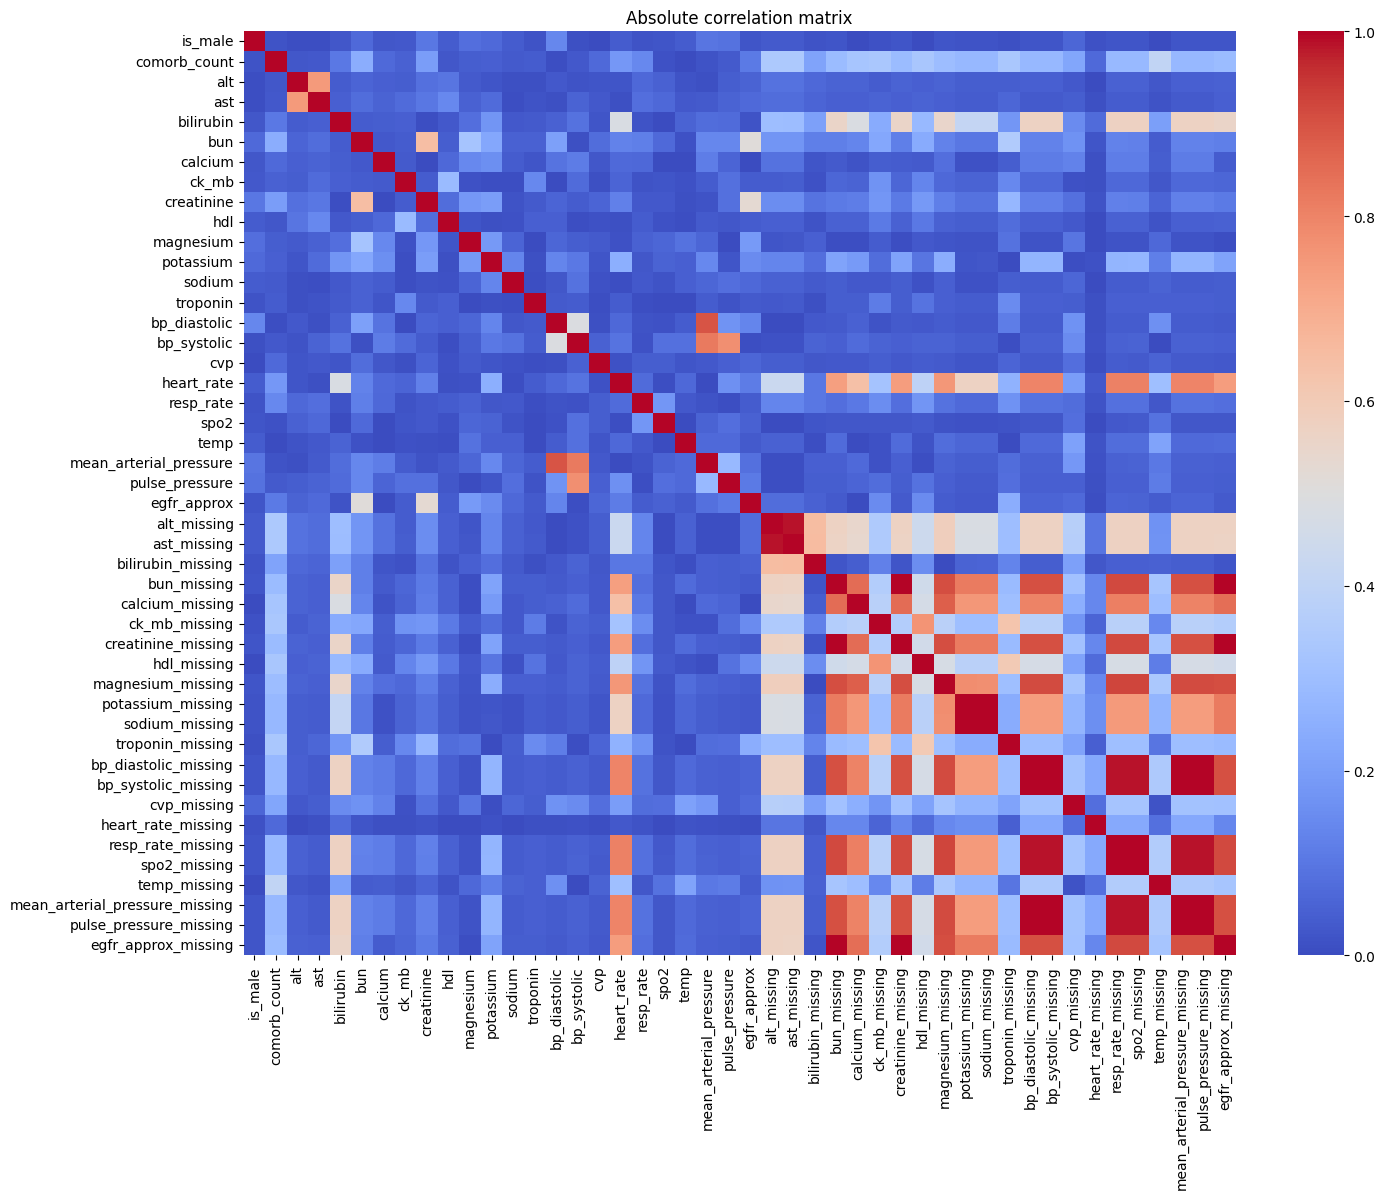


Removed 14 cols with correlation > 0.8: ['mean_arterial_pressure', 'ast_missing', 'calcium_missing', 'creatinine_missing', 'magnesium_missing', 'potassium_missing', 'sodium_missing', 'bp_diastolic_missing', 'bp_systolic_missing', 'resp_rate_missing', 'spo2_missing', 'mean_arterial_pressure_missing', 'pulse_pressure_missing', 'egfr_approx_missing']


In [ ]:
# Ensure all relevant numeric columns, including flags, are considered for correlation
numeric_cols_for_corr = [col for col in df_final.columns if col in numeric_cols or col in flag_cols]
corr_matrix = df_final[numeric_cols_for_corr].corr().abs()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Absolute correlation matrix')
plt.show()

threshold = 0.8
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > threshold)]

print(f"\nRemoved {len(to_drop)} cols with correlation > {threshold}: {to_drop}")
df_final = df_final.drop(columns=to_drop)
numeric_cols = [c for c in numeric_cols if c not in to_drop]

### Capping

In [ ]:
def cap_outliers(df, iqr_mult=5.0):
    '''
    Capping outliers ONLY on selected continuous numerical columns.
Skips: ID, target, _missing flags, binary/discrete variables.
'''
    df_cap = df.copy()

    cols_to_cap = ['other_comorb', 'comorb_count', 'alt', 'ast',
    'bilirubin', 'bun', 'calcium', 'cholesterol', 'ck_mb', 'creatinine',
    'hdl', 'magnesium', 'potassium', 'sodium', 'troponin', 'bp_diastolic',
    'bp_systolic', 'cvp', 'heart_rate', 'resp_rate', 'spo2', 'temp','pulse_pressure', 'egfr_approx']

    cols_to_cap = [c for c in cols_to_cap if c in df_cap.columns]

    print(f"Capping {iqr_mult}×IQR {len(cols_to_cap)}")

    for col in cols_to_cap:
        Q1 = df_cap[col].quantile(0.25)
        Q3 = df_cap[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - iqr_mult * IQR
        upper = Q3 + iqr_mult * IQR


        df_cap[col] = df_cap[col].clip(lower=lower, upper=upper)

    return df_cap


df_final = cap_outliers(df_final, iqr_mult=5.0)

Capping 5.0×IQR 23


### Final check

In [ ]:

print("After capping: ", len(df_final))
print(df_final['has_heart_disease'].value_counts(normalize=True))
print("\nFinal description :")
df_final.info()
print("\nMissing values:", df_final.isnull().sum())

After capping:  46520
has_heart_disease
1    0.534845
0    0.465155
Name: proportion, dtype: float64

Final description :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46520 entries, 0 to 46519
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   is_male             46520 non-null  int64  
 1   has_heart_disease   46520 non-null  int64  
 2   respiratory         46520 non-null  int64  
 3   diabetes            46520 non-null  int64  
 4   renal               46520 non-null  int64  
 5   liver               46520 non-null  int64  
 6   other_comorb        46520 non-null  int64  
 7   comorb_count        46520 non-null  int64  
 8   alt                 46520 non-null  float64
 9   ast                 46520 non-null  float64
 10  bilirubin           46520 non-null  float64
 11  bun                 46520 non-null  float64
 12  calcium             46520 non-null  float64
 13  ck_mb               46520 non

##Model Comparison

### 4 models comparison

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/tmp/ipython-input-4292536262.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results['Accuracy']

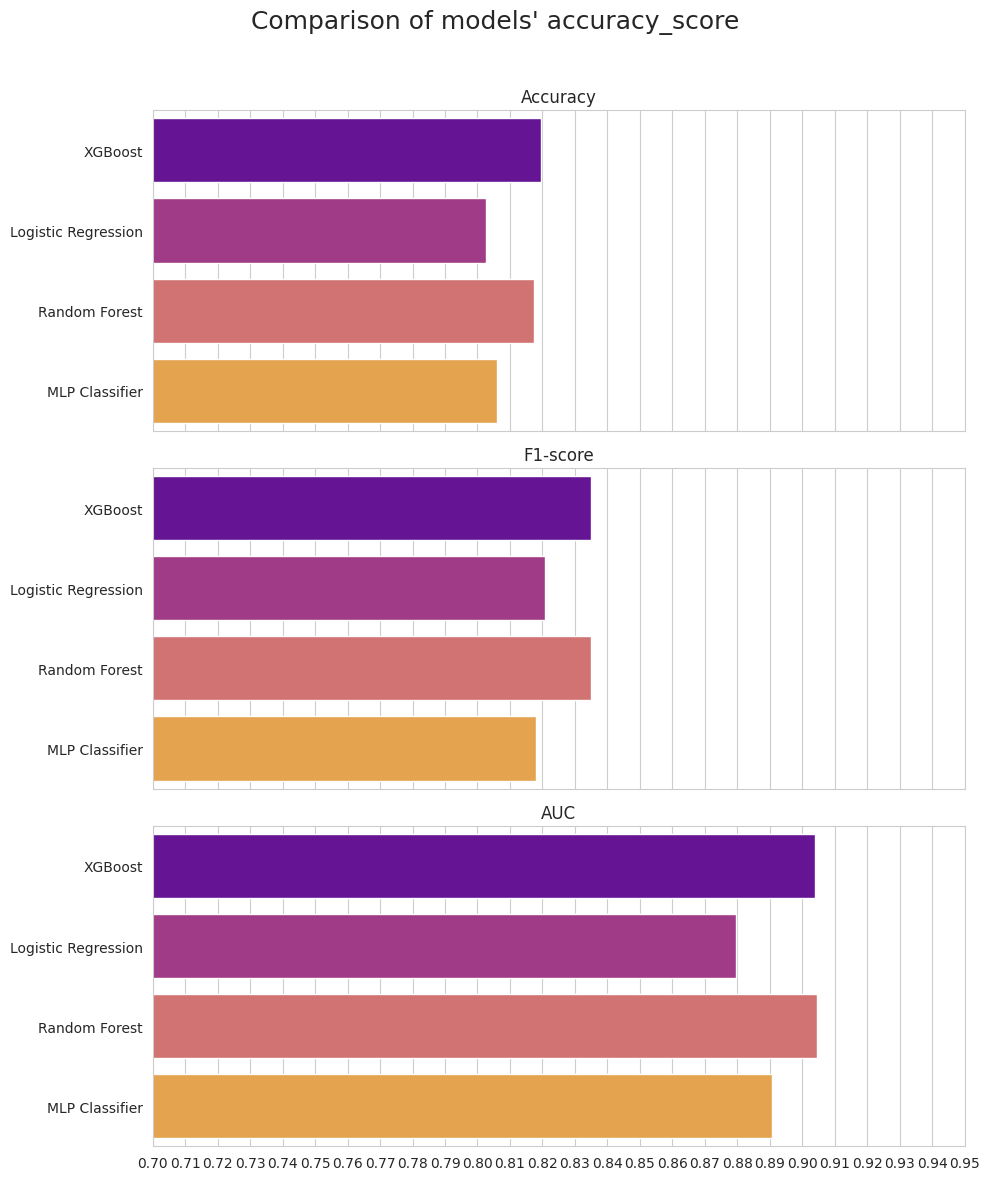

In [ ]:
y = df_final['has_heart_disease']
X = df_final.drop(columns=['subject_id', 'has_heart_disease'], errors='ignore')
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

models = {
    'XGBoost': xgb.XGBClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'MLP Classifier': MLPClassifier(random_state=42)
}


results = {
    'Accuracy': {},
    'F1-score': {},
    'AUC': {}
}


for name, model in models.items():
    logging.info(f"\n Training of the {name} model") # Replaced print with logging

    pipeline_steps = []

    if name not in ['XGBoost', 'Random Forest']:
        pipeline_steps.append(('imputer', SimpleImputer(strategy='median')))

    pipeline_steps.append(('transformer', QuantileTransformer(output_distribution='normal')))
    pipeline_steps.append(('classifier', model))

    pipeline = Pipeline(steps=pipeline_steps)

    pipeline.fit(X_train, y_train)
    preds_test = pipeline.predict(X_test)
    preds_proba_test = pipeline.predict_proba(X_test)[:, 1]


    results['Accuracy'][name] = accuracy_score(y_test, preds_test)
    results['F1-score'][name] = f1_score(y_test, preds_test)
    results['AUC'][name] = roc_auc_score(y_test, preds_proba_test)

    logging.info(f"Accuracy: {results['Accuracy'][name]:.4f}") # Replaced print with logging
    logging.info(f"F1-score: {results['F1-score'][name]:.4f}") # Replaced print with logging
    logging.info(f"AUC: {results['AUC'][name]:.4f}") # Replaced print with logging

x_ticks = np.arange(0.7, 0.96, 0.01)

sns.set_style("whitegrid")
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
fig.suptitle('Comparison of models\' accuracy_score', fontsize=18)

sns.barplot(x=list(results['Accuracy'].values()), y=list(results['Accuracy'].keys()), ax=axes[0], palette="plasma")
axes[0].set_title('Accuracy')
axes[0].set_xlim(0.7, 0.95)
axes[0].set_xticks(x_ticks)
axes[0].tick_params(axis='y', rotation=0)


sns.barplot(x=list(results['F1-score'].values()), y=list(results['F1-score'].keys()), ax=axes[1], palette="plasma")
axes[1].set_title('F1-score')
axes[1].set_xlim(0.7, 0.95)
axes[1].set_xticks(x_ticks)
axes[1].tick_params(axis='y', rotation=0)


sns.barplot(x=list(results['AUC'].values()), y=list(results['AUC'].keys()), ax=axes[2], palette="plasma")
axes[2].set_title('AUC')
axes[2].set_xlim(0.7, 0.95)
axes[2].set_xticks(x_ticks)
axes[2].tick_params(axis='y', rotation=0)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

###XGBvsRandomForest Comparison

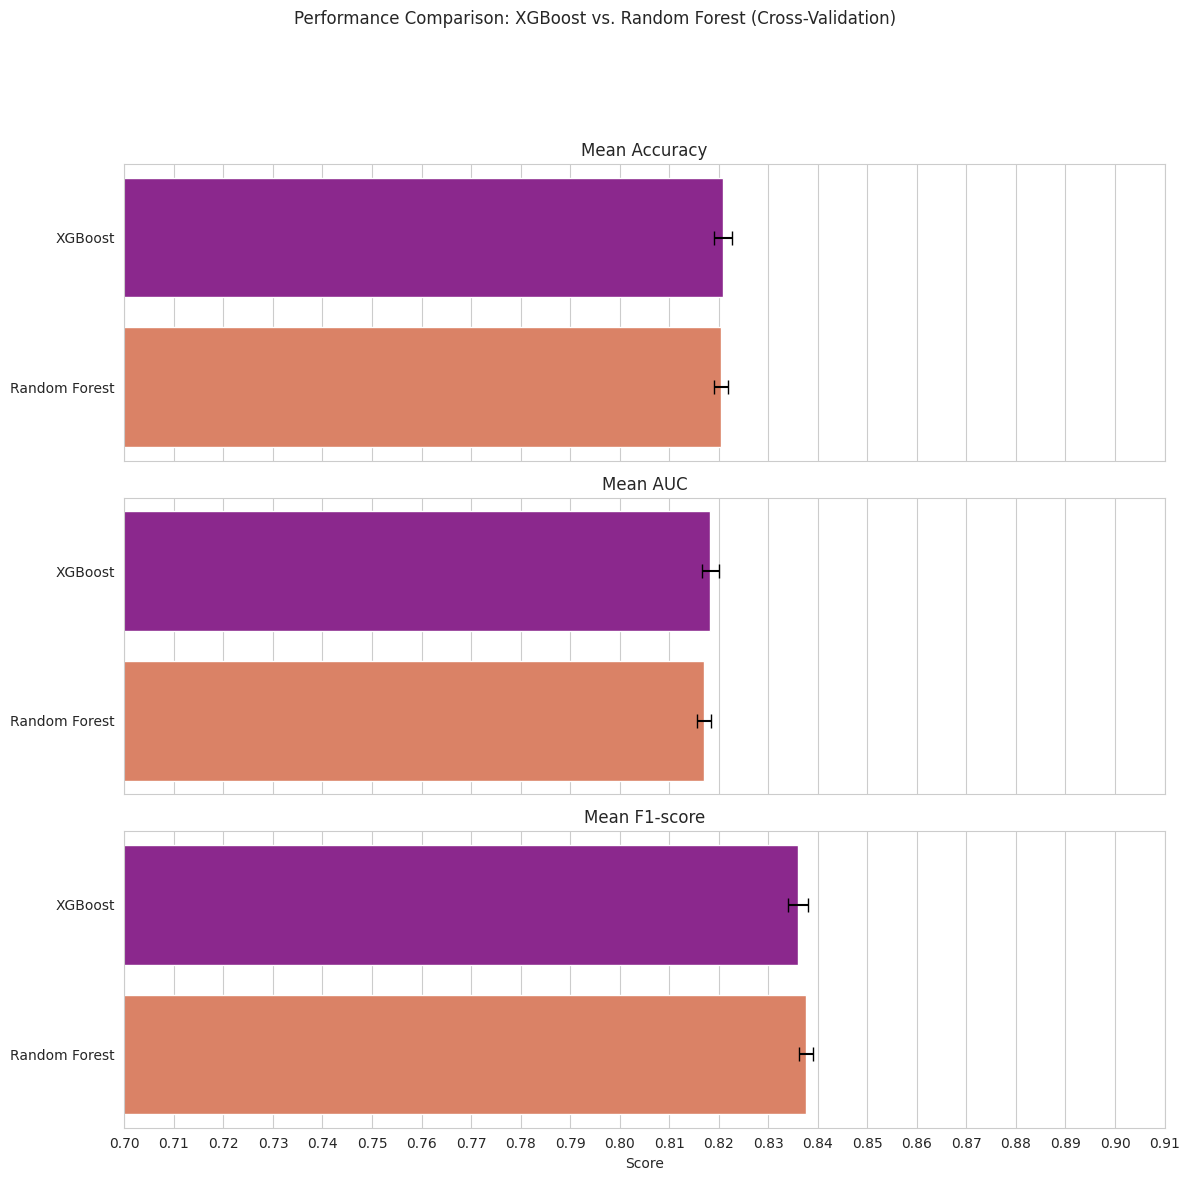

In [ ]:
warnings.filterwarnings('ignore')

numeric_cols_to_convert = ['heart_rate', 'bp_systolic', 'troponin', 'cholesterol', 'creatinine', 'bun', 'ast', 'alt']
for col in numeric_cols_to_convert:
    if col in df_final.columns:
        df_final[col] = pd.to_numeric(df_final[col], errors='coerce')

numeric_cols = df_final.select_dtypes(include=['float64', 'int64']).columns.difference(['subject_id', 'has_heart_disease'])
df_final[numeric_cols] = df_final[numeric_cols].replace([np.inf, -np.inf], np.nan)

y = df_final['has_heart_disease']
X = df_final.drop(columns=['subject_id', 'has_heart_disease'], errors='ignore')

models = {
    'XGBoost': xgb.XGBClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
}

scorers = {
    'Accuracy': make_scorer(accuracy_score),
    'AUC': make_scorer(roc_auc_score),
    'F1-score': make_scorer(f1_score)
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results_mean = { 'Accuracy': {}, 'AUC': {}, 'F1-score': {} }
results_std = { 'Accuracy': {}, 'AUC': {}, 'F1-score': {} }

for name, model in models.items():
    logging.info(f"\n Training and Cross-Validation Evaluation: {name}")

    pipeline = Pipeline(steps=[
        ('classifier', model)
    ])

    for metric_name, scorer in scorers.items():
        scores = cross_val_score(pipeline, X, y, cv=cv, scoring=scorer, n_jobs=-1)
        results_mean[metric_name][name] = np.mean(scores)
        results_std[metric_name][name] = np.std(scores)
        logging.info(f"   {metric_name}: {np.mean(scores):.4f} +/- {np.std(scores):.4f}")


sns.set_style("whitegrid")
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
fig.suptitle('Performance Comparison: XGBoost vs. Random Forest (Cross-Validation)', fontsize=12)


x_ticks = np.arange(0.7, 0.91, 0.01)

sns.barplot(y=list(results_mean['Accuracy'].keys()), x=list(results_mean['Accuracy'].values()), ax=axes[0], palette="plasma")
axes[0].set_title('Mean Accuracy')
axes[0].set_xlim(0.7, 0.91)
axes[0].set_xticks(x_ticks)
axes[0].tick_params(axis='y', rotation=0)
axes[0].errorbar(x=list(results_mean['Accuracy'].values()), y=list(results_mean['Accuracy'].keys()), xerr=list(results_std['Accuracy'].values()), fmt='none', c='black', capsize=5)
axes[0].set_xlabel('')
axes[0].set_ylabel('')

# Plot AUC
sns.barplot(y=list(results_mean['AUC'].keys()), x=list(results_mean['AUC'].values()), ax=axes[1], palette="plasma")
axes[1].set_title('Mean AUC')
axes[1].set_xlim(0.7, 0.91)
axes[1].set_xticks(x_ticks)
axes[1].tick_params(axis='y', rotation=0)
axes[1].errorbar(x=list(results_mean['AUC'].values()), y=list(results_mean['AUC'].keys()), xerr=list(results_std['AUC'].values()), fmt='none', c='black', capsize=5)
axes[1].set_xlabel('')
axes[1].set_ylabel('')

# Plot F1-score
sns.barplot(y=list(results_mean['F1-score'].keys()), x=list(results_mean['F1-score'].values()), ax=axes[2], palette="plasma")
axes[2].set_title('Mean F1-score')
axes[2].set_xlim(0.7, 0.91)
axes[2].set_xticks(x_ticks)
axes[2].tick_params(axis='y', rotation=0)
axes[2].errorbar(x=list(results_mean['F1-score'].values()), y=list(results_mean['F1-score'].keys()), xerr=list(results_std['F1-score'].values()), fmt='none', c='black', capsize=5)
axes[2].set_xlabel('Score')
axes[2].set_ylabel('')

plt.tight_layout(rect=[0, 0, 1, 0.91])
plt.show()


#XGB

##XGB training

In [ ]:

y = df_final['has_heart_disease']
X = df_final.drop(columns=['SUBJECT_ID', 'has_heart_disease'], errors='ignore')

params = {
"n_estimators": 750,
  "max_depth": 8,
  "learning_rate": 0.021024333398663577,
  "subsample": 0.5145979460843341,
  "colsample_bytree": 0.6901065169970275,
  "gamma": 0.923432759000714,
  "min_child_weight": 9,
  "reg_alpha": 0.3475986048606899,
  "reg_lambda": 0.00024541040885605963
}
scale_pos_weight = (y == 0).sum() / (y == 1).sum()

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_accuracy, cv_f1, cv_auc, cv_conf_matrices = [], [], [], []
tprs, aucs = [], []
cv_reports_df = pd.DataFrame()  # Collect into DataFrame
mean_fpr = np.linspace(0, 1, 100)
cv_feature_importances = pd.DataFrame(index=X.columns)
fold_number = 1

print("Cross-validation")

for train_index, val_index in kf.split(X, y):
    print(f"\n--- Fold {fold_number}/5 ---")
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, **params, random_state=42)
    model.fit(X_train, y_train)

    preds_val = model.predict(X_val)
    preds_proba_val = model.predict_proba(X_val)[:, 1]

    cv_accuracy.append(accuracy_score(y_val, preds_val))
    cv_f1.append(f1_score(y_val, preds_val))
    cv_auc.append(roc_auc_score(y_val, preds_proba_val))
    cv_conf_matrices.append(confusion_matrix(y_val, preds_val))

    report_dict = classification_report(y_val, preds_val, output_dict=True)
    temp_df = pd.DataFrame(report_dict).transpose()
    cv_reports_df = pd.concat([cv_reports_df, temp_df])

    fpr, tpr, _ = roc_curve(y_val, preds_proba_val)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0 # Corrected indentation
    aucs.append(auc(fpr, tpr))

    cv_feature_importances[f'Fold_{fold_number}'] = model.feature_importances_

    fold_number += 1



print(" Cross-validation summary")
print(f"Average Accuracy: {np.mean(cv_accuracy):.4f} (+/- {np.std(cv_accuracy):.4f})")
print(f"Average F1-score: {np.mean(cv_f1):.4f} (+/- {np.std(cv_f1):.4f})")
print(f"Average AUC: {np.mean(cv_auc):.4f} (+/- {np.std(cv_auc):.4f})")

avg_report = cv_reports_df.groupby(cv_reports_df.index).mean(numeric_only=True)
print("\nAverage cross-validation metrics (Precision, Recall, F1-score):")
print(avg_report[['precision', 'recall', 'f1-score']].loc[['0', '1']].rename(
    index={'0': 'Class 0 (No disease)', '1': 'Class 1 (Disease)'}))

Cross-validation

--- Fold 1/5 ---

--- Fold 2/5 ---

--- Fold 3/5 ---

--- Fold 4/5 ---

--- Fold 5/5 ---
 Cross-validation summary
Average Accuracy: 0.8273 (+/- 0.0015)
Average F1-score: 0.8399 (+/- 0.0012)
Average AUC: 0.9118 (+/- 0.0018)

Average cross-validation metrics (Precision, Recall, F1-score):
                      precision    recall  f1-score
Class 0 (No disease)   0.820559  0.804704  0.812548
Class 1 (Disease)      0.832970  0.846952  0.839898



##Post-Modeling Analysis


### Confusion Matrix


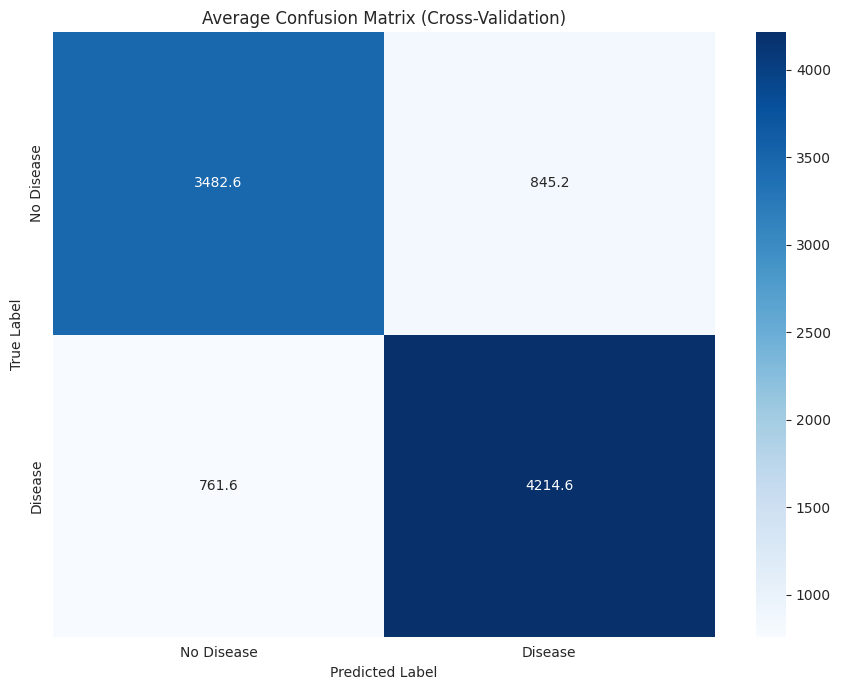

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a new figure and axes for the Confusion Matrix
plt.figure(figsize=(9, 7)) # Adjust size for a single plot

# Heatmap of the Confusion Matrix (Average Confusion Matrix)
mean_conf_matrix = np.mean(cv_conf_matrices, axis=0)
sns.heatmap(mean_conf_matrix, annot=True, fmt='.1f', cmap='Blues')
plt.title('Average Confusion Matrix (Cross-Validation)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0.5, 1.5], ['No Disease', 'Disease']) # Adjust x-tick positions for single subplot
plt.yticks([0.5, 1.5], ['No Disease', 'Disease']) # Adjust y-tick positions for single subplot
plt.tight_layout()
plt.show()

### ROC curve

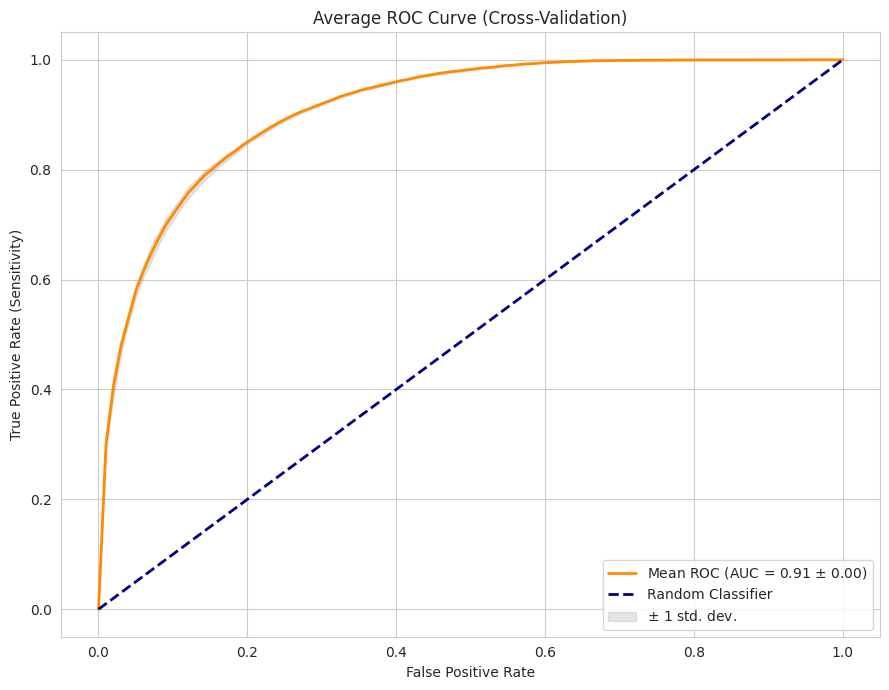

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc

# Create a new figure and axes for the ROC Curve
plt.figure(figsize=(9, 7)) # Adjust size for a single plot

# ROC Curve (Average ROC Curve)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc_val = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(mean_fpr, mean_tpr, color='darkorange', lw=2,
         label=f'Mean ROC (AUC = {mean_auc_val:.2f} $\pm$ {std_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.title('Average ROC Curve (Cross-Validation)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

### Top 20 Features by Gain Importance

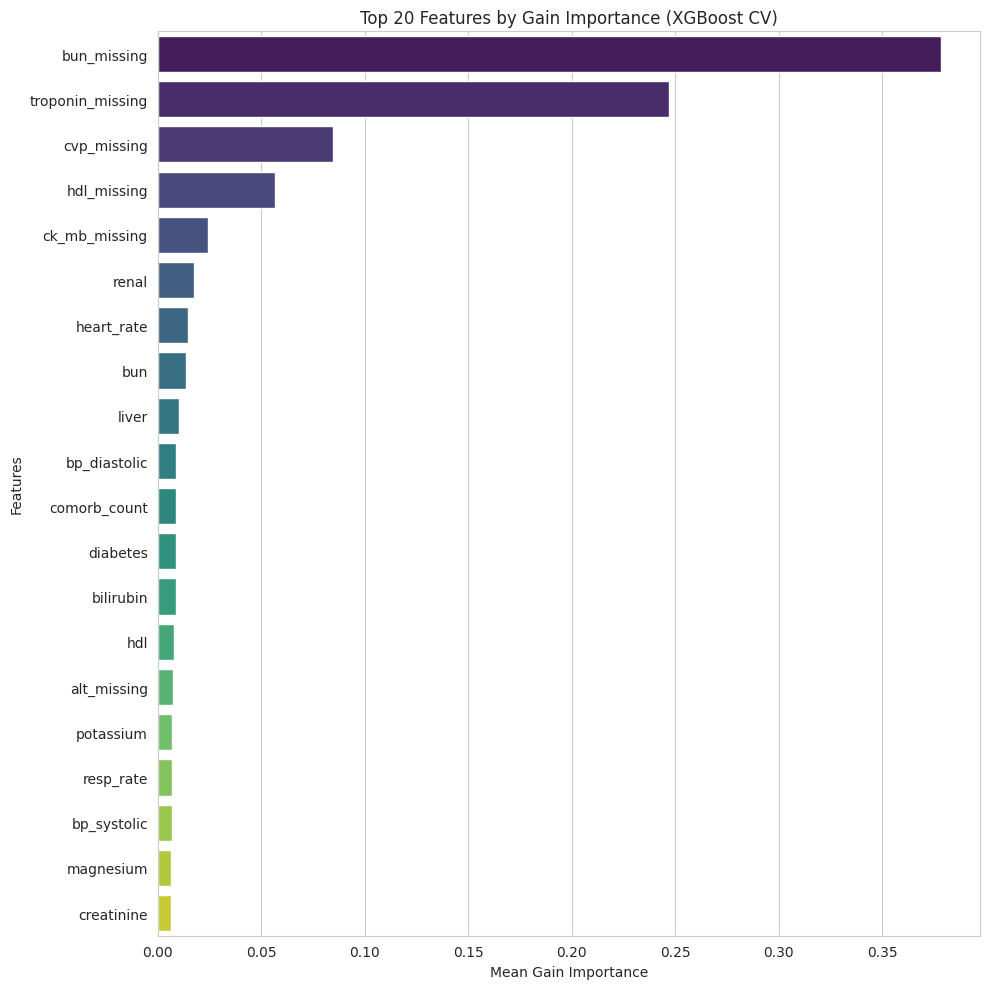

In [ ]:
mean_gain_importance = cv_feature_importances.mean(axis=1).sort_values(ascending=False)
top_20_gain_features = mean_gain_importance.head(20)

plt.figure(figsize=(10, 10))
sns.barplot(x=top_20_gain_features.values, y=top_20_gain_features.index, palette='viridis')
plt.xlabel('Mean Gain Importance')
plt.ylabel('Features')
plt.title('Top 20 Features by Gain Importance (XGBoost CV)')
plt.tight_layout()
plt.show()

## Select Top 20 Features

In [ ]:
selected_features_20 = top_20_gain_features.index.tolist()
X_reduced_20 = X[selected_features_20].copy()

print(f"Original number of features in X: {X.shape[1]}")
print(f"Number of selected features: {len(selected_features_20)}")
print("Reduced feature set (first 5 rows):")
print(X_reduced_20.head())

Original number of features in X: 37
Number of selected features: 20
Reduced feature set (first 5 rows):
   bun_missing  troponin_missing  cvp_missing  hdl_missing  ck_mb_missing  \
0            0                 0            0            0              0   
1            0                 0            0            0              0   
2            0                 1            1            1              1   
3            0                 1            0            1              1   
4            0                 0            1            0              1   

   renal  heart_rate   bun  liver  bp_diastolic  comorb_count  diabetes  \
0      1        93.0  28.0      0          58.0            28         1   
1      1       100.0  12.0      0          63.0            10         0   
2      0        70.5   9.5      0          57.0             5         0   
3      1        83.0  23.0      1          65.0            25         0   
4      0        60.0  16.0      0          49.0          

## Re-run Model Comparison with Top 20 Features



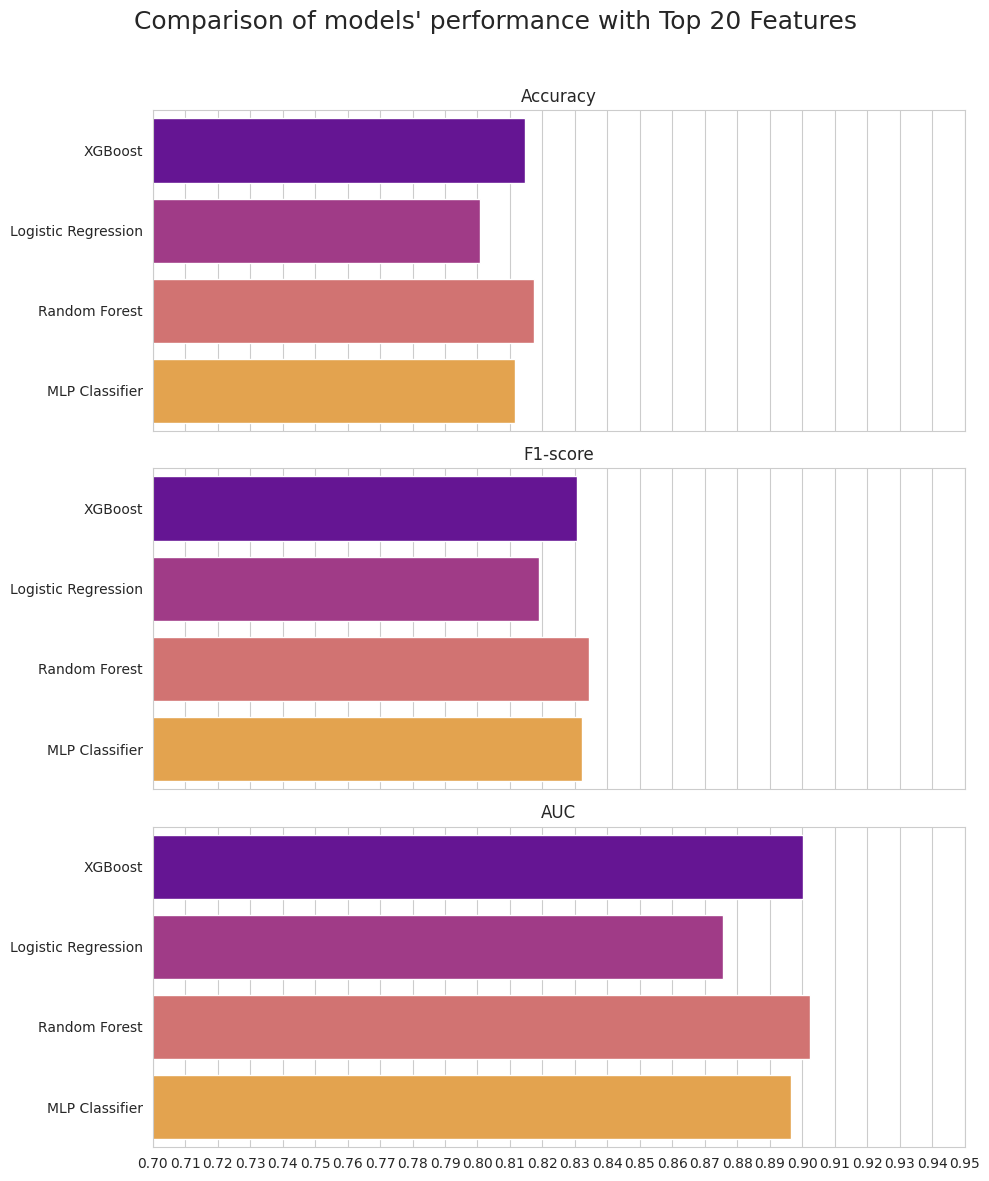

In [ ]:
X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(
    X_reduced_20, y, test_size=0.2, stratify=y, random_state=42
)

models = {
    'XGBoost': xgb.XGBClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'MLP Classifier': MLPClassifier(random_state=42)
}

results_reduced = {
    'Accuracy': {},
    'F1-score': {},
    'AUC': {}
}

for name, model in models.items():
    logging.info(f"\n Training of the {name} model with reduced features")

    pipeline_steps = []

    # Only add imputer if the model is not tree-based (XGBoost, Random Forest handle NaNs natively)
    if name not in ['XGBoost', 'Random Forest']:
        pipeline_steps.append(('imputer', SimpleImputer(strategy='median')))

    pipeline_steps.append(('transformer', QuantileTransformer(output_distribution='normal')))
    pipeline_steps.append(('classifier', model))

    pipeline = Pipeline(steps=pipeline_steps)

    pipeline.fit(X_train_reduced, y_train)
    preds_test = pipeline.predict(X_test_reduced)
    preds_proba_test = pipeline.predict_proba(X_test_reduced)[:, 1]

    results_reduced['Accuracy'][name] = accuracy_score(y_test, preds_test)
    results_reduced['F1-score'][name] = f1_score(y_test, preds_test)
    results_reduced['AUC'][name] = roc_auc_score(y_test, preds_proba_test)

    logging.info(f"Accuracy: {results_reduced['Accuracy'][name]:.4f}")
    logging.info(f"F1-score: {results_reduced['F1-score'][name]:.4f}")
    logging.info(f"AUC: {results_reduced['AUC'][name]:.4f}")

x_ticks = np.arange(0.7, 0.96, 0.01)

sns.set_style("whitegrid")
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
fig.suptitle('Comparison of models\' performance with Top 20 Features', fontsize=18)

sns.barplot(x=list(results_reduced['Accuracy'].values()), y=list(results_reduced['Accuracy'].keys()), ax=axes[0], palette="plasma")
axes[0].set_title('Accuracy')
axes[0].set_xlim(0.7, 0.95)
axes[0].set_xticks(x_ticks)
axes[0].tick_params(axis='y', rotation=0)

sns.barplot(x=list(results_reduced['F1-score'].values()), y=list(results_reduced['F1-score'].keys()), ax=axes[1], palette="plasma")
axes[1].set_title('F1-score')
axes[1].set_xlim(0.7, 0.95)
axes[1].set_xticks(x_ticks)
axes[1].tick_params(axis='y', rotation=0)

sns.barplot(x=list(results_reduced['AUC'].values()), y=list(results_reduced['AUC'].keys()), ax=axes[2], palette="plasma")
axes[2].set_title('AUC')
axes[2].set_xlim(0.7, 0.95)
axes[2].set_xticks(x_ticks)
axes[2].tick_params(axis='y', rotation=0)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
y = df_final['has_heart_disease']
X = X_reduced_20

scale_pos_weight = (y == 0).sum() / (y == 1).sum()

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_accuracy, cv_f1, cv_auc, cv_conf_matrices = [], [], [], []
tprs, aucs = [], []
cv_reports_df = pd.DataFrame()  # Collect into DataFrame
mean_fpr = np.linspace(0, 1, 100)
cv_feature_importances = pd.DataFrame(index=X.columns)
fold_number = 1

print("Cross-validation with Top 20 Features")

for train_index, val_index in kf.split(X, y):
    print(f"\n--- Fold {fold_number}/5 ---")
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, **params, random_state=42)
    model.fit(X_train, y_train)

    preds_val = model.predict(X_val)
    preds_proba_val = model.predict_proba(X_val)[:, 1]

    cv_accuracy.append(accuracy_score(y_val, preds_val))
    cv_f1.append(f1_score(y_val, preds_val))
    cv_auc.append(roc_auc_score(y_val, preds_proba_val))
    cv_conf_matrices.append(confusion_matrix(y_val, preds_val))

    report_dict = classification_report(y_val, preds_val, output_dict=True)
    temp_df = pd.DataFrame(report_dict).transpose()
    cv_reports_df = pd.concat([cv_reports_df, temp_df])

    fpr, tpr, _ = roc_curve(y_val, preds_proba_val)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs.append(auc(fpr, tpr))

    cv_feature_importances[f'Fold_{fold_number}'] = model.feature_importances_

    fold_number += 1



print(" Cross-validation summary (Top 20 Features)")
print(f"Average Accuracy: {np.mean(cv_accuracy):.4f} (+/- {np.std(cv_accuracy):.4f})")
print(f"Average F1-score: {np.mean(cv_f1):.4f} (+/- {np.std(cv_f1):.4f})")
print(f"Average AUC: {np.mean(cv_auc):.4f} (+/- {np.std(cv_auc):.4f})")

avg_report = cv_reports_df.groupby(cv_reports_df.index).mean(numeric_only=True)
print("\nAverage cross-validation metrics (Precision, Recall, F1-score) with Top 20 Features:")
print(avg_report[['precision', 'recall', 'f1-score']].loc[['0', '1']].rename(
    index={'0': 'Class 0 (No disease)', '1': 'Class 1 (Disease)'}))

Cross-validation with Top 20 Features

--- Fold 1/5 ---

--- Fold 2/5 ---

--- Fold 3/5 ---

--- Fold 4/5 ---

--- Fold 5/5 ---
 Cross-validation summary (Top 20 Features)
Average Accuracy: 0.8229 (+/- 0.0021)
Average F1-score: 0.8356 (+/- 0.0020)
Average AUC: 0.9073 (+/- 0.0016)

Average cross-validation metrics (Precision, Recall, F1-score) with Top 20 Features:
                      precision    recall  f1-score
Class 0 (No disease)   0.814930  0.801100  0.807952
Class 1 (Disease)      0.829533  0.841767  0.835603


### Confusion Matrix for XGBoost with TOP 20 features

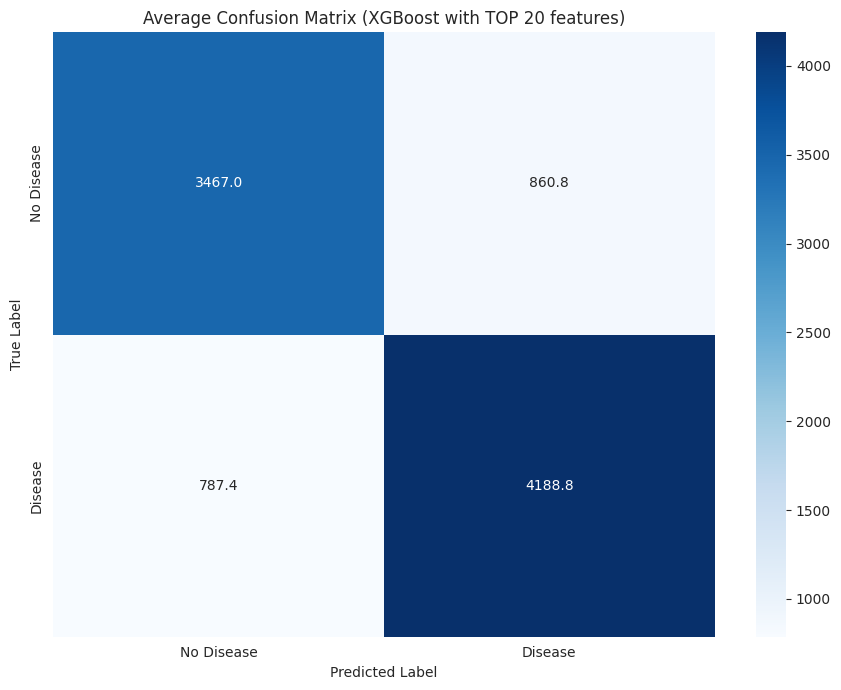

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a new figure and axes for the Confusion Matrix
plt.figure(figsize=(9, 7)) # Adjust size for a single plot

# Heatmap of the Confusion Matrix (Average Confusion Matrix)
# Ensure Zu_i78h1YxAf has been executed to load correct cv_conf_matrices for ALL features
mean_conf_matrix = np.mean(cv_conf_matrices, axis=0)
sns.heatmap(mean_conf_matrix, annot=True, fmt='.1f', cmap='Blues')
plt.title('Average Confusion Matrix (XGBoost with TOP 20 features)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0.5, 1.5], ['No Disease', 'Disease'])
plt.yticks([0.5, 1.5], ['No Disease', 'Disease'])
plt.tight_layout()
plt.show()

### ROC Curve for XGBoost with TOP 20 features

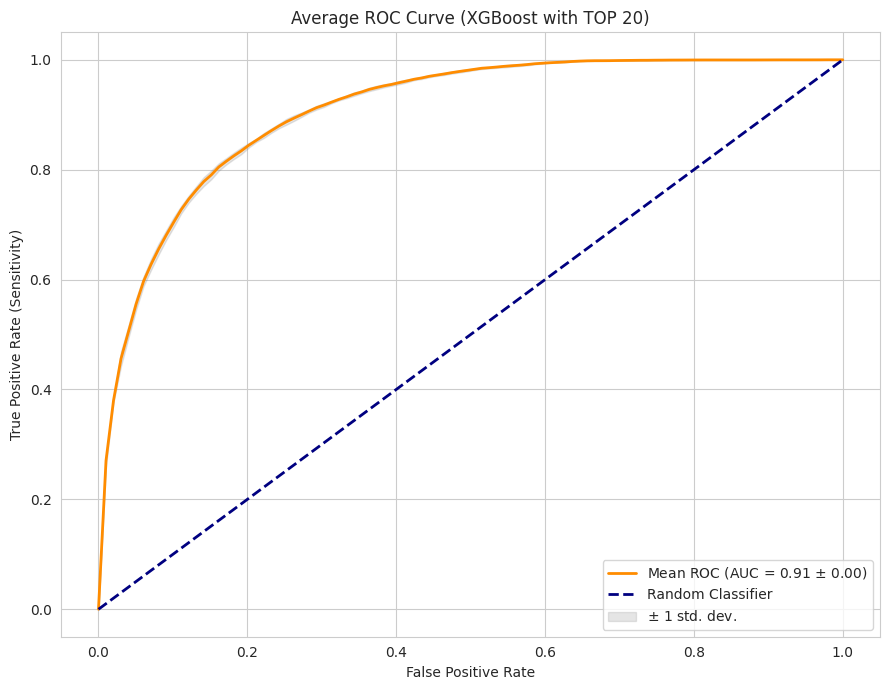

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc

# Create a new figure and axes for the ROC Curve
plt.figure(figsize=(9, 7)) # Adjust size for a single plot

# ROC Curve (Average ROC Curve)
# Ensure Zu_i78h1YxAf has been executed to load correct tprs, mean_fpr, aucs for TOp 20
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc_val = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(mean_fpr, mean_tpr, color='darkorange', lw=2,
         label=f'Mean ROC (AUC = {mean_auc_val:.2f} $\pm$ {std_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.title('Average ROC Curve (XGBoost with TOP 20)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

### Feature Importance (Gain)

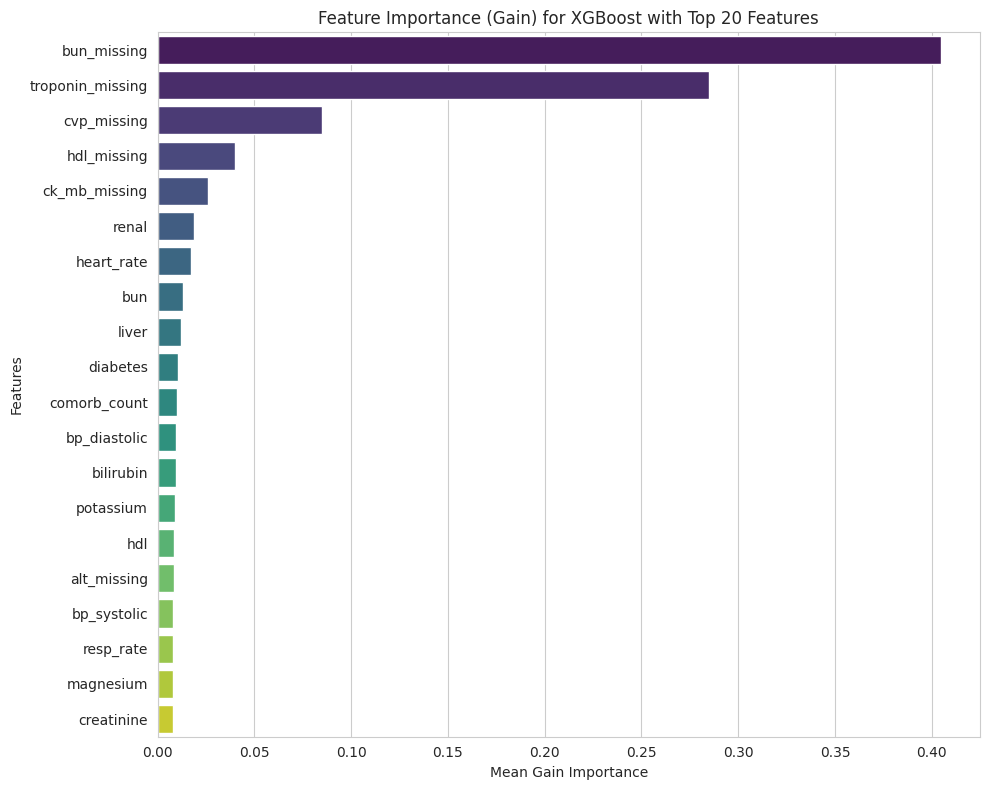

In [ ]:
mean_gain_importance_reduced = cv_feature_importances.mean(axis=1).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=mean_gain_importance_reduced.values, y=mean_gain_importance_reduced.index, palette='viridis')
plt.xlabel('Mean Gain Importance')
plt.ylabel('Features')
plt.title('Feature Importance (Gain) for XGBoost with Top 20 Features')
plt.tight_layout()
plt.show()

## Optuna Hyperparameter Tuning to XGBoost



In [ ]:
!pip install optuna
import optuna

def objective(trial):
    """Objective function for Optuna to optimize XGBoost hyperparameters."""
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'n_estimators': trial.suggest_int('n_estimators', 703, 800),
        'max_depth': trial.suggest_int('max_depth', 7, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.020191344, 0.022),
        'subsample': trial.suggest_float('subsample', 0.5, 0.55),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.69, 0.71),
        'gamma': trial.suggest_float('gamma', 0.91, 0.95),
        'min_child_weight': trial.suggest_int('min_child_weight', 7, 9),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.32, 0.35, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0001, 0.0003, log=True),
        'use_label_encoder': False,
        'random_state': 42
    }

    model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, **param)

    # Use StratifiedKFold for cross-validation on the full X and y
    kf_optuna = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(model, X, y, cv=kf_optuna, scoring='roc_auc', n_jobs=-1)

    return np.mean(auc_scores)

# Create an Optuna study and optimize
logging.info("Starting Optuna hyperparameter tuning...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

logging.info("Optuna tuning finished.")
print(f"\nBest trial value (AUC): {study.best_value:.4f}")
print("Best hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# Update the params dictionary with the best parameters found by Optuna
params = study.best_params

[I 2026-02-11 17:29:12,101] A new study created in memory with name: no-name-f5227cc9-e598-4b15-83ac-69cfbd92c7e8


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-11 17:29:54,094] Trial 0 finished with value: 0.9115648580136846 and parameters: {'n_estimators': 728, 'max_depth': 8, 'learning_rate': 0.0210151255753451, 'subsample': 0.5319861198975737, 'colsample_bytree': 0.6909986285028873, 'gamma': 0.9368181230513455, 'min_child_weight': 7, 'reg_alpha': 0.3411316972261303, 'reg_lambda': 0.00012002129523036306}. Best is trial 0 with value: 0.9115648580136846.
[I 2026-02-11 17:30:23,801] Trial 1 finished with value: 0.9116499506843885 and parameters: {'n_estimators': 754, 'max_depth': 7, 'learning_rate': 0.020420654930495382, 'subsample': 0.5060009534994304, 'colsample_bytree': 0.6921742798059671, 'gamma': 0.949949549606516, 'min_child_weight': 9, 'reg_alpha': 0.340628353437542, 'reg_lambda': 0.0001921915450494614}. Best is trial 1 with value: 0.9116499506843885.
[I 2026-02-11 17:30:53,783] Trial 2 finished with value: 0.9115127989505563 and parameters: {'n_estimators': 774, 'max_depth': 7, 'learning_rate': 0.020772452591801382, 'subsamp

# Random Forest

## Optuna Hyperparameter Tuning for Random Forest

In [ ]:
!pip install optuna
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer
import numpy as np # Added for np.mean

def objective_rf(trial):
    """Objective function for Optuna to optimize RandomForest hyperparameters."""
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.5, 0.7, 0.9]),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'random_state': 42,
        'n_jobs': -1  # Use all available cores
    }

    model = RandomForestClassifier(**param)

    kf_optuna = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(model, X, y, cv=kf_optuna, scoring='roc_auc', n_jobs=-1)

    return np.mean(auc_scores)

logging.info("Starting Optuna hyperparameter tuning for Random Forest...")
study_rf = optuna.create_study(direction='maximize', study_name='RandomForest_Optimization')
study_rf.optimize(objective_rf, n_trials=50, show_progress_bar=True)

logging.info("Optuna tuning for Random Forest finished.")
print(f"\nBest trial value (AUC) for Random Forest: {study_rf.best_value:.4f}")
print("Best hyperparameters for Random Forest:")
for key, value in study_rf.best_params.items():
    print(f"  {key}: {value}")

# Update params for Random Forest training
params_rf = study_rf.best_params


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 8.1 MB/s eta 0:00:00


[I 2026-02-12 13:34:16,790] A new study created in memory with name: RandomForest_Optimization


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-12 13:36:09,775] Trial 0 finished with value: 0.9073064275804585 and parameters: {'n_estimators': 440, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 0 with value: 0.9073064275804585.
[I 2026-02-12 13:38:04,646] Trial 1 finished with value: 0.900569384125221 and parameters: {'n_estimators': 686, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 0 with value: 0.9073064275804585.
[I 2026-02-12 13:49:16,295] Trial 2 finished with value: 0.9068320557367462 and parameters: {'n_estimators': 489, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 0.9, 'criterion': 'entropy'}. Best is trial 0 with value: 0.9073064275804585.
[I 2026-02-12 13:54:57,097] Trial 3 finished with value: 0.9020779993421055 and parameters: {'n_estimators': 528, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_feat

KeyboardInterrupt: 

## Optimized Random Forest Training (All Features)

### Random Forest training (All Features)

In [ ]:
# Initialize Random Forest model with best parameters from Optuna
params_rf = {'n_estimators': 778, 'max_depth': 20, 'min_samples_split': 13, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'criterion': 'entropy'}

rf_model_optimized = RandomForestClassifier(**params_rf, random_state=42)

# Set up StratifiedKFold for cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_accuracy_rf_opt, cv_f1_rf_opt, cv_auc_rf_opt, cv_conf_matrices_rf_opt = [], [], [], []
tprs_rf_opt, aucs_rf_opt = [], []
cv_reports_df_rf_opt = pd.DataFrame()
mean_fpr_rf_opt = np.linspace(0, 1, 100)
cv_feature_importances_rf_opt = pd.DataFrame(index=X.columns)
fold_number_rf_opt = 1

print("Cross-validation for Optimized Random Forest (All Features)")

for train_index, val_index in kf.split(X, y):
    print(f"\n--- Fold {fold_number_rf_opt}/5 ---")
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Fit the Optimized Random Forest model
    rf_model_optimized.fit(X_train, y_train)

    preds_val = rf_model_optimized.predict(X_val)
    preds_proba_val = rf_model_optimized.predict_proba(X_val)[:, 1]

    cv_accuracy_rf_opt.append(accuracy_score(y_val, preds_val))
    cv_f1_rf_opt.append(f1_score(y_val, preds_val))
    cv_auc_rf_opt.append(roc_auc_score(y_val, preds_proba_val))
    cv_conf_matrices_rf_opt.append(confusion_matrix(y_val, preds_val))

    report_dict = classification_report(y_val, preds_val, output_dict=True)
    temp_df = pd.DataFrame(report_dict).transpose()
    cv_reports_df_rf_opt = pd.concat([cv_reports_df_rf_opt, temp_df])

    fpr, tpr, _ = roc_curve(y_val, preds_proba_val)
    tprs_rf_opt.append(np.interp(mean_fpr_rf_opt, fpr, tpr))
    tprs_rf_opt[-1][0] = 0.0
    aucs_rf_opt.append(auc(fpr, tpr))

    cv_feature_importances_rf_opt[f'Fold_{fold_number_rf_opt}'] = rf_model_optimized.feature_importances_

    fold_number_rf_opt += 1

print(" Optimized Random Forest Cross-validation summary (All Features)")
print(f"Average Accuracy: {np.mean(cv_accuracy_rf_opt):.4f} (+/- {np.std(cv_accuracy_rf_opt):.4f})")
print(f"Average F1-score: {np.mean(cv_f1_rf_opt):.4f} (+/- {np.std(cv_f1_rf_opt):.4f})")
print(f"Average AUC: {np.mean(cv_auc_rf_opt):.4f} (+/- {np.std(cv_auc_rf_opt):.4f})")

avg_report_rf_opt = cv_reports_df_rf_opt.groupby(cv_reports_df_rf_opt.index).mean(numeric_only=True)
print("\nAverage cross-validation metrics (Precision, Recall, F1-score) for Optimized Random Forest:")
print(avg_report_rf_opt[['precision', 'recall', 'f1-score']].loc[['0', '1']].rename(
    index={'0': 'Class 0 (No disease)', '1': 'Class 1 (Disease)'}))

Cross-validation for Optimized Random Forest (All Features)

--- Fold 1/5 ---

--- Fold 2/5 ---

--- Fold 3/5 ---

--- Fold 4/5 ---

--- Fold 5/5 ---
 Optimized Random Forest Cross-validation summary (All Features)
Average Accuracy: 0.8214 (+/- 0.0021)
Average F1-score: 0.8397 (+/- 0.0020)
Average AUC: 0.9078 (+/- 0.0013)

Average cross-validation metrics (Precision, Recall, F1-score) for Optimized Random Forest:
                      precision    recall  f1-score
Class 0 (No disease)   0.840416  0.760479  0.798449
Class 1 (Disease)      0.807602  0.874402  0.839674


### Optimized Random Forest Feature Importance (All Features)

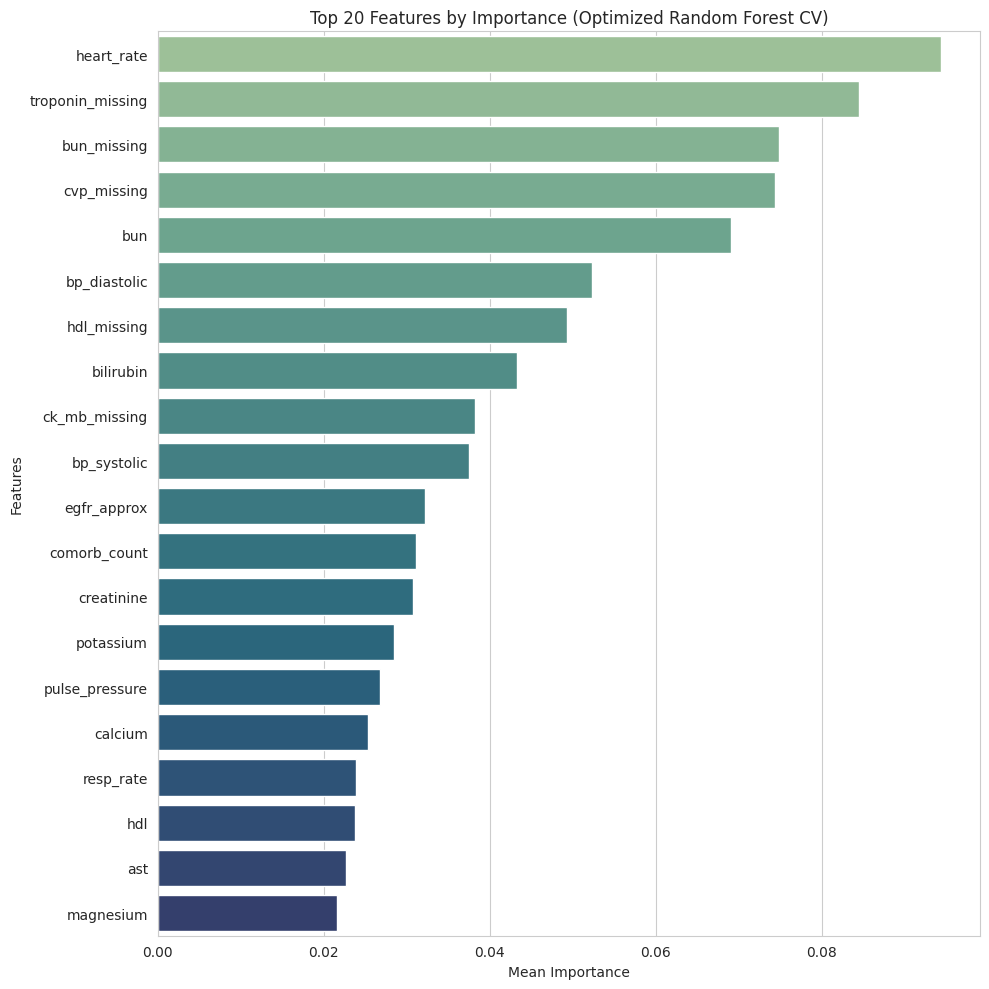

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

mean_gain_importance_rf_opt = cv_feature_importances_rf_opt.mean(axis=1).sort_values(ascending=False)
top_20_gain_features_rf_opt = mean_gain_importance_rf_opt.head(20)

plt.figure(figsize=(10, 10))
sns.barplot(x=top_20_gain_features_rf_opt.values, y=top_20_gain_features_rf_opt.index, palette='crest')
plt.xlabel('Mean Importance')
plt.ylabel('Features')
plt.title('Top 20 Features by Importance (Optimized Random Forest CV)')
plt.tight_layout()
plt.show()

### Optimized Random Forest ROC Curve (All Features)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc

plt.figure(figsize=(9, 7))
mean_tpr_rf_opt = np.mean(tprs_rf_opt, axis=0)
mean_tpr_rf_opt[-1] = 1.0
mean_auc_val_rf_opt = auc(mean_fpr_rf_opt, mean_tpr_rf_opt)
std_auc_rf_opt = np.std(aucs_rf_opt)

plt.plot(mean_fpr_rf_opt, mean_tpr_rf_opt, color='darkgreen', lw=2,
         label=f'Mean ROC (AUC = {mean_auc_val_rf_opt:.2f} $\pm$ {std_auc_rf_opt:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

std_tpr_rf_opt = np.std(tprs_rf_opt, axis=0)
tprs_upper_rf_opt = np.minimum(mean_tpr_rf_opt + std_tpr_rf_opt, 1)
tprs_lower_rf_opt = np.maximum(mean_tpr_rf_opt - std_tpr_rf_opt, 0)
plt.fill_between(mean_fpr_rf_opt, tprs_lower_rf_opt, tprs_upper_rf_opt, color='lightgreen', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.title('Average ROC Curve (Optimized Random Forest with ALL features)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

<>:12: SyntaxWarning: invalid escape sequence '\p'
<>:12: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-3717468592.py:12: SyntaxWarning: invalid escape sequence '\p'
  label=f'Mean ROC (AUC = {mean_auc_val_rf_opt:.2f} $\pm$ {std_auc_rf_opt:.2f})')


NameError: name 'tprs_rf_opt' is not defined

<Figure size 900x700 with 0 Axes>

### Optimized Random Forest Confusion Matrix (All Features)

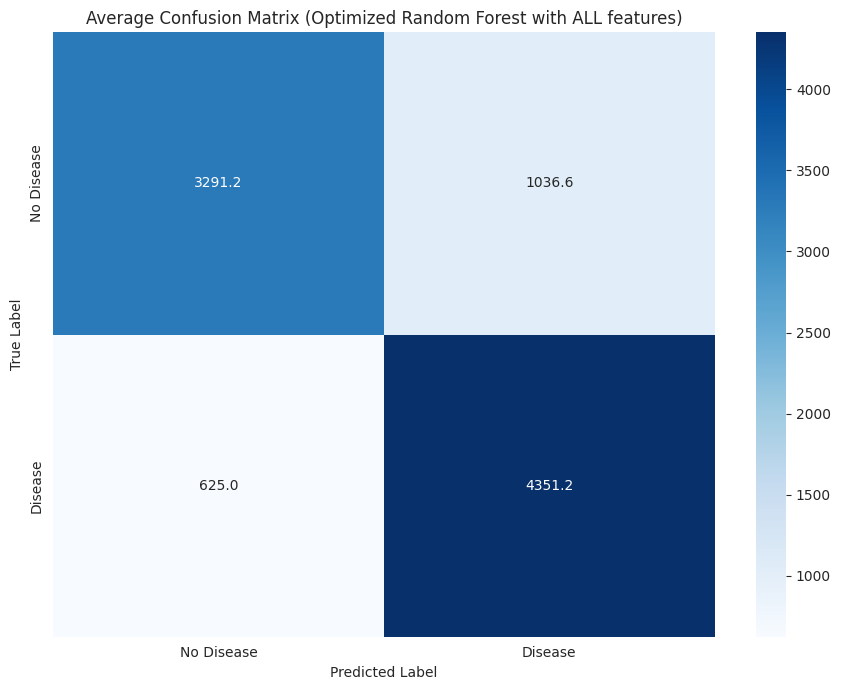

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(9, 7))
mean_conf_matrix_rf_opt = np.mean(cv_conf_matrices_rf_opt, axis=0)
sns.heatmap(mean_conf_matrix_rf_opt, annot=True, fmt='.1f', cmap='Blues')
plt.title('Average Confusion Matrix (Optimized Random Forest with ALL features)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0.5, 1.5], ['No Disease', 'Disease'])
plt.yticks([0.5, 1.5], ['No Disease', 'Disease'])
plt.tight_layout()
plt.show()